In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:

image_directory = 'Dataset/Train/images/'
mask_directory = 'Dataset/Train/masks/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [4]:

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [5]:

#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


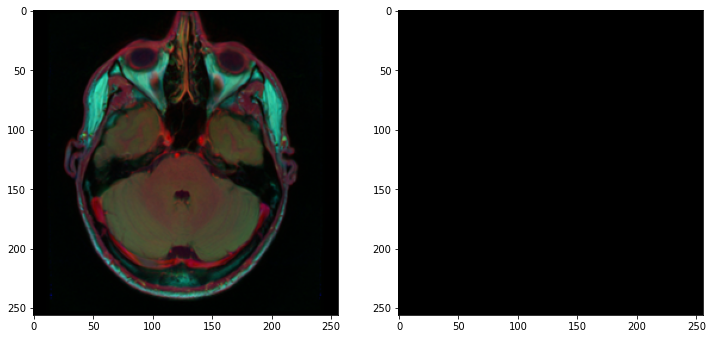

In [6]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()



In [7]:
#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8


In [8]:

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

###############################################################################

from models import Attention_ResUNet, UNet, Attention_UNet, dice_coef, dice_coef_loss, jacard_coef

att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())


Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

 conv2d_16 (Conv2D)             (None, 256, 256, 64  110656      ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 64  36928       ['activation_16[0][0]']          
          

 ormalization)                  8)                                                                
                                                                                                  
 add_1 (Add)                    (None, 128, 128, 12  0           ['batch_normalization_24[0][0]', 
                                8)                                'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 128, 128, 12  0           ['add_1[0][0]']                  
                                8)                                                                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 128)  0          ['activation_22[0][0]']          
                                                                                                  
 conv2d_25

                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 16, 16, 512)  524800      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_34 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_29 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 512)  262656      ['activation_29[0][0]']          
          

                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 1)    257         ['activation_35[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 32, 32, 1)    0           ['conv2d_45[0][0]']              
                                                                                                  
 up_sampling2d_6 (UpSampling2D)  (None, 64, 64, 1)   0           ['activation_36[0][0]']          
                                                                                                  
 lambda_1 (Lambda)              (None, 64, 64, 256)  0           ['up_sampling2d_6[0][0]']        
                                                                                                  
 multiply_1 (Multiply)          (None, 64, 64, 256)  0           ['lambda_1[0][0]',               
          

C:\Users\Public\Miniconda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 activation_38 (Activation)     (None, 64, 64, 256)  0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 128)  32896       ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_44 (BatchN  (None, 64, 64, 128)  512        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_52 (Conv2D)             (None, 64, 64, 128)  16512       ['activation_39[0][0]']          
          

                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 64  36928      ['conv2d_60[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 128, 128, 64  16448       ['activation_20[0][0]']          
                                )                                                                 
                                                                                                  
 add_11 (Add)                   (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_59[0][0]']              
                                                                                                  
 activatio

In [9]:
start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=3)
stop3 = datetime.now()

Epoch 1/3
79/79 [==============================] - 1090s 14s/step - loss: 0.1119 - accuracy: 0.8973 - jacard_coef: 0.0199 - val_loss: 0.0454 - val_accuracy: 0.9836 - val_jacard_coef: 0.0202
Epoch 2/3
79/79 [==============================] - 1082s 14s/step - loss: 0.0403 - accuracy: 0.9840 - jacard_coef: 0.0277 - val_loss: 0.0347 - val_accuracy: 0.9834 - val_jacard_coef: 0.0162
Epoch 3/3
79/79 [==============================] - 1213s 15s/step - loss: 0.0241 - accuracy: 0.9860 - jacard_coef: 0.0326 - val_loss: 0.0224 - val_accuracy: 0.9848 - val_jacard_coef: 0.0232


In [11]:
execution_time_Att_res_Unet = stop3-start3
print("Attention ResUNet execution time is: ", execution_time_Att_res_Unet)

att_res_unet_model.save('Attention_ResUNet_3epochs_B_focal.hdf5')

Attention ResUNet execution time is:  0:56:24.783369


In [12]:
import pandas as pd    

In [13]:
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

In [14]:
with open('att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)

In [15]:
history = att_res_unet_history

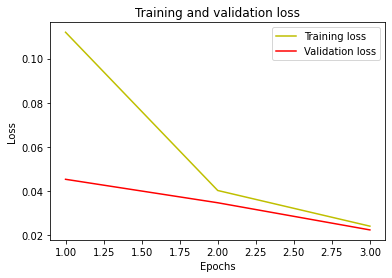

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

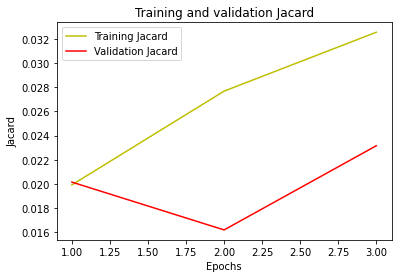

In [17]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

In [18]:
model_path = "Attention_ResUNet_3epochs_B_focal.hdf5"
model = tf.keras.models.load_model(model_path, compile=False)

In [32]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 365ms/step


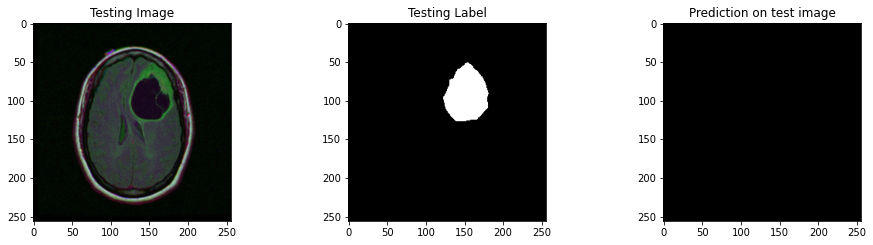

In [31]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [29]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7029468
